In [1]:
# Cell 1: Imports and class selection
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Selected classes (just 3 for assignment)
selected_classes = ['person', 'dog', 'cat']


2025-05-11 17:23:58.527154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746984238.768630      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746984238.839829      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Cell 2: Utility and Dataset class (returns correct label)

def parse_annotation(xml_file, classes):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        cls = obj.find('name').text
        if cls in classes:
            xmlbox = obj.find('bndbox')
            b = [int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
                 int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text)]
            boxes.append(b)
            labels.append(classes.index(cls))
    return boxes, labels

class PascalDataset(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ann_dir, classes, batch_size=1, img_size=224):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.classes = classes
        self.batch_size = batch_size
        self.img_size = img_size
        self.ids = [f[:-4] for f in os.listdir(ann_dir) if f.endswith('.xml')]

    def __len__(self):
        return len(self.ids) // self.batch_size

    def __getitem__(self, idx):
        batch_ids = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_boxes = []
        batch_labels = []
        for i in batch_ids:
            img_path = os.path.join(self.img_dir, f"{i}.jpg")
            ann_path = os.path.join(self.ann_dir, f"{i}.xml")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            boxes, labels = parse_annotation(ann_path, self.classes)
            if len(boxes) == 0:
                continue  # skip if no valid object

            # Resize img and boxes
            img_resized = cv2.resize(img, (self.img_size, self.img_size))
            scale_x = self.img_size / w
            scale_y = self.img_size / h
            boxes = np.array(boxes) * [scale_x, scale_y, scale_x, scale_y]

            batch_imgs.append(img_resized / 255.0)
            batch_boxes.append(boxes[0])     # only first box
            batch_labels.append(labels[0])   # only first label

        if len(batch_imgs) == 0:
            random_idx = np.random.randint(0, len(self))
            return self.__getitem__(random_idx)

        return (np.array(batch_imgs, dtype=np.float32),
                np.array(batch_boxes, dtype=np.float32),
                np.array(batch_labels, dtype=np.int32))


In [10]:
# Cell 3: Create dataset instance and test shape
train_data = PascalDataset(
    img_dir='../input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages',
    ann_dir='../input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations',
    classes=selected_classes,
    batch_size=1
)

# Test sample shape
imgs, boxes, labels = train_data[0]
print("Image batch shape:", imgs.shape)   # (1, 224, 224, 3)
print("Box batch shape:", boxes.shape)    # (1, 4)
print("Label batch shape:", labels.shape) # (1,)
print("Label value:", labels[0], "->", selected_classes[labels[0]])


Image batch shape: (1, 224, 224, 3)
Box batch shape: (1, 4)
Label batch shape: (1,)
Label value: 0 -> person


In [11]:
# Cell 4: Build model
backbone = MobileNetV2(include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='imagenet')
backbone.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = backbone(inputs)
bbox_out = layers.Dense(4, activation='linear', name='bbox')(x)
class_out = layers.Dense(len(selected_classes), activation='softmax', name='class')(x)
model = models.Model(inputs, [bbox_out, class_out])

model.summary()


I0000 00:00:1746984434.813232      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746984434.813905      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox (Dense)              │ (None, 4)              │          5,124 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 3)              │          3,843 │ mobilenetv2_1.00_224[… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

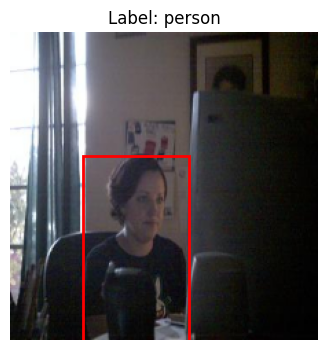

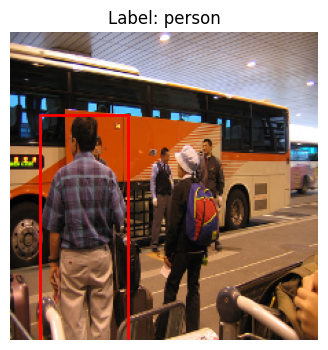

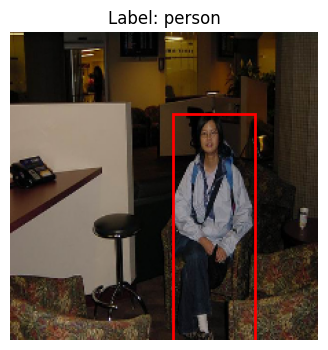

In [12]:
# Cell 5: Visualize 3 random valid samples (with correct label)
shown = 0
max_attempts = 20
attempts = 0
while shown < 3 and attempts < max_attempts:
    imgs, boxes, labels = train_data[np.random.randint(0, len(train_data))]
    if imgs.shape[0] == 0 or boxes.shape[0] == 0:
        continue
    img = imgs[0]
    box = boxes[0]
    label = labels[0]
    if len(box) != 4 or np.any(np.isnan(box)):
        continue
    x1, y1, x2, y2 = box
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
    plt.title(f"Label: {selected_classes[label]}")
    plt.axis('off')
    plt.show()
    shown += 1
if shown < 3:
    print(f"Warning: Only {shown} valid samples could be shown. Check your dataset!")


In [15]:
# Cell 6: Data generator and training (uses true label)
def data_gen(dataset, num_classes=len(selected_classes)):
    while True:
        imgs, boxes, labels = dataset[np.random.randint(0, len(dataset))]
        if imgs.shape[0] == 0 or boxes.shape[0] == 0:
            continue  # skip empty batch
        img = imgs[0]
        box = boxes[0]
        label = labels[0]
        y_class = tf.keras.utils.to_categorical(label, num_classes)
        yield (np.expand_dims(img, axis=0),
               (np.expand_dims(box, axis=0), np.expand_dims(y_class, axis=0)))

# Use tf.data.Dataset.from_generator for model.fit
output_signature = (
    tf.TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(1, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(1, len(selected_classes)), dtype=tf.float32)
    )
)
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(train_data, num_classes=len(selected_classes)),
    output_signature=output_signature
)

model.compile(
    optimizer='adam',
    loss={
        'bbox': 'mse',
        'class': 'categorical_crossentropy'
    },
    metrics={
        'bbox': 'mse',
        'class': 'accuracy'
    }
)

# Quick training (small steps, fast)
history = model.fit(
    train_dataset,
    steps_per_epoch=20,
    epochs=30
)


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - bbox_loss: 13126.6279 - bbox_mse: 13126.6279 - class_accuracy: 0.8169 - class_loss: 0.9845 - loss: 13127.6133
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bbox_loss: 13040.2979 - bbox_mse: 13040.2979 - class_accuracy: 0.5567 - class_loss: 0.7491 - loss: 13041.0469
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bbox_loss: 12600.7568 - bbox_mse: 12600.7568 - class_accuracy: 0.9777 - class_loss: 0.1710 - loss: 12600.9277
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bbox_loss: 8803.1016 - bbox_mse: 8803.1016 - class_accuracy: 0.7319 - class_loss: 0.5452 - loss: 8803.6465
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bbox_loss: 7158.9482 - bbox_mse: 7158.9482 - class_accuracy: 0.9554 - class_loss: 0.1819 - loss: 7159.1304
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bbox_loss: 9525.6836 - bbox_mse: 9525.6836 - class_accuracy: 0.9166 - class_loss: 0.3457 - loss: 9526.0293
Epoch 7/30
20/20 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


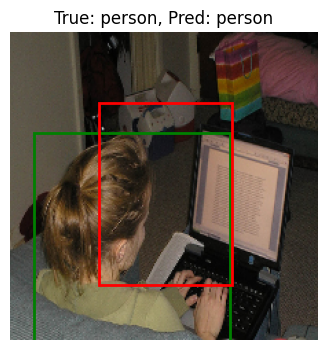

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


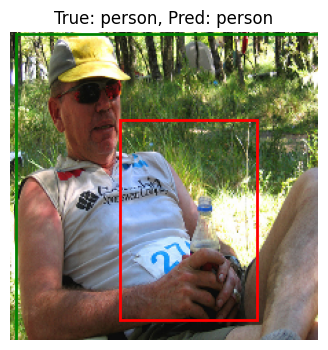

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


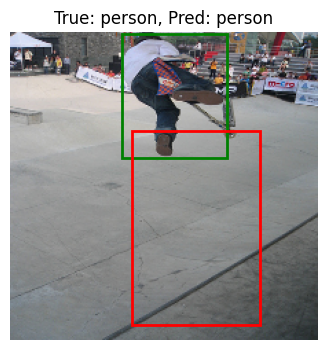

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


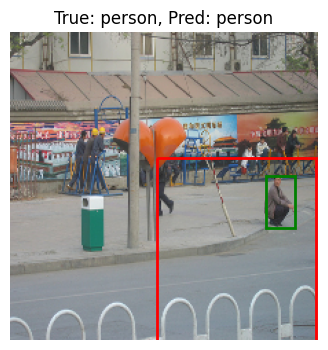

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


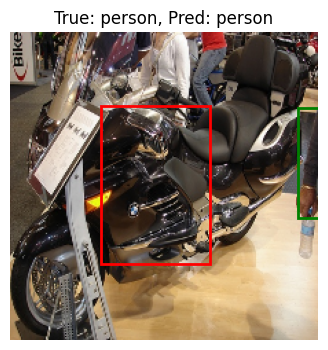

In [16]:
for _ in range(5):
    imgs, boxes, labels = train_data[np.random.randint(0, len(train_data))]
    img = imgs[0]
    true_box = boxes[0]
    true_label = labels[0]
    pred_box, pred_class = model.predict(np.expand_dims(img, axis=0))
    pred_box = pred_box[0]
    pred_class_idx = np.argmax(pred_class[0])
    pred_class_name = selected_classes[pred_class_idx]
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    # True box in green
    plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2]-true_box[0], true_box[3]-true_box[1], fill=False, color='green', linewidth=2, label='True'))
    # Predicted box in red
    plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0], pred_box[3]-pred_box[1], fill=False, color='red', linewidth=2, label='Pred'))
    plt.title(f"True: {selected_classes[true_label]}, Pred: {pred_class_name}")
    plt.axis('off')
    plt.show()


In [18]:
model.save_weights('mobilenet_detector_weights.weights.h5')


In [19]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea
    return interArea / unionArea if unionArea > 0 else 0

# Evaluate on 50 random samples
tp, fp, fn = 0, 0, 0
for _ in range(50):
    imgs, boxes, labels = train_data[np.random.randint(0, len(train_data))]
    img = imgs[0]
    true_box = boxes[0]
    true_label = labels[0]
    pred_box, pred_class = model.predict(np.expand_dims(img, axis=0))
    pred_box = pred_box[0]
    pred_class_idx = np.argmax(pred_class[0])
    if pred_class_idx == true_label and iou(pred_box, true_box) > 0.5:
        tp += 1
    else:
        fp += 1

precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


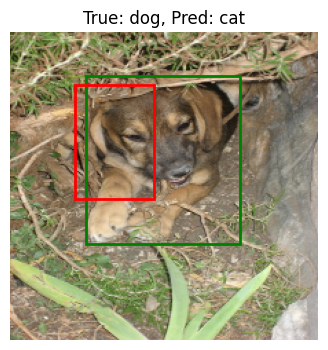

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


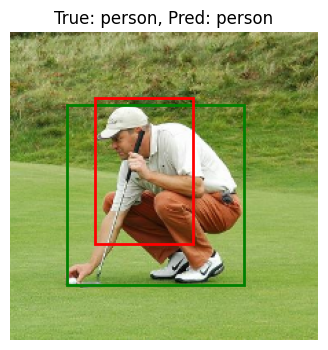

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


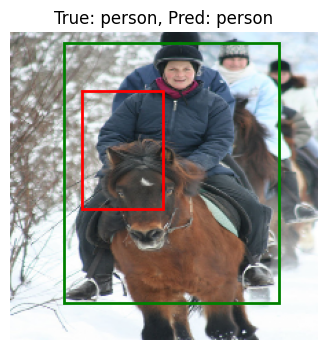

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


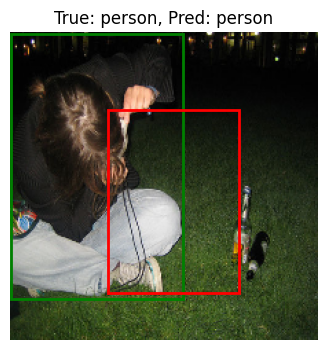

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


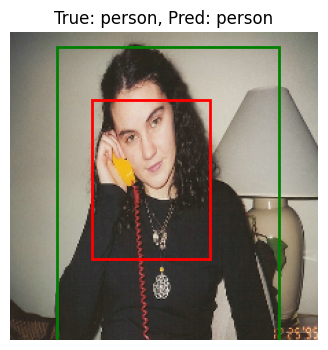

In [20]:
for _ in range(5):
    imgs, boxes, labels = train_data[np.random.randint(0, len(train_data))]
    img = imgs[0]
    true_box = boxes[0]
    true_label = labels[0]
    pred_box, pred_class = model.predict(np.expand_dims(img, axis=0))
    pred_box = pred_box[0]
    pred_class_idx = np.argmax(pred_class[0])
    pred_class_name = selected_classes[pred_class_idx]
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2]-true_box[0], true_box[3]-true_box[1], fill=False, color='green', linewidth=2, label='True'))
    plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0], pred_box[3]-pred_box[1], fill=False, color='red', linewidth=2, label='Pred'))
    plt.title(f"True: {selected_classes[true_label]}, Pred: {pred_class_name}")
    plt.axis('off')
    plt.show()
